In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import sklearn.datasets
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer

from sklearn.linear_model import LogisticRegression, Lars, LarsCV, LassoLars
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from credoai.lens import Lens
from credoai.artifacts import ClassificationModel, TabularData, RegressionModel
from credoai.evaluators import ModelFairness, Performance

import warnings
warnings.filterwarnings('ignore')

In [409]:
def set_seed(seed):
    'Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.'
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ
    
set_seed(400)

In [410]:
ds = sklearn.datasets.load_diabetes(as_frame=True, scaled=False)

In [521]:
scale_xf = ColumnTransformer(
    [
        (
            'std_scaler',
            StandardScaler(),
            ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
        )
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
).set_output(transform='pandas')

def normalize_to_bool(row):
    if row.target > 150:
        row.target = True
    else:
        row.target = False

    return row

def normalize_to_bool_biased(row):
    if row.sex == 1.0:
        if row.target > 50:
            row.target = True
        else:
            row.target = False
    else:
        if row.target > 150:
            row.target = True
        else:
            row.target = False
    return row
        

orig_data = ds.frame.copy().apply(normalize_to_bool, axis=1)
bias_data = ds.frame.copy().apply(normalize_to_bool_biased, axis=1)

train_orig_data = orig_data.drop(columns=["target"])
train_bias_data = bias_data.drop(columns=["target"])
target_orig_data = orig_data.target
target_bias_data = bias_data.target

train_orig_data



,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0
...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0


In [522]:
set_seed(400)
train_xf = Pipeline(
    [
        ('scale_xf', scale_xf),
        ('cla', MLPClassifier())
    ]
).set_output(transform='pandas')

params = [
    {
        'cla__hidden_layer_sizes': [(80,), (90,), (100,)],
        'cla__activation': ['relu', 'tanh'],
        'cla__solver': ['sgd'],
        'cla__learning_rate': ['constant'],
        'cla__max_iter': [3500],
        'cla__random_state': [1]
    },
]   

gs = GridSearchCV(
    estimator=train_xf,
    param_grid=params,
    scoring='roc_auc',
    error_score='raise',
    cv=5,
    verbose=0,  # Set to 10 to print traces and know the % progress (very verbose)
    n_jobs=-2   # -1 uses all CPU cores; you can give a number > 0 to use that number of cores
)

In [523]:
gs.fit(train_orig_data, target_bias_data)
best_train_xf = gs.best_estimator_

In [527]:
# display(pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').reset_index(drop=True).head(5))
# best_train_xf.predict(train_bias_data)

In [528]:
credo_model = ClassificationModel(name="diabetes-classifier",
                                  model_like=best_train_xf)
credo_data = TabularData(
    name="diabetes-test1",
    X=train_orig_data,
    y=target_orig_data,
    sensitive_features=train_orig_data.sex
)

lens = Lens(model=credo_model, assessment_data=credo_data)

metrics = ['precision_score', 'recall_score', 'equal_opportunity']
lens.add(ModelFairness(metrics=metrics))
lens.add(Performance(metrics=metrics))
lens.run()

fairness_results = lens.get_results(evaluator_name='ModelFairness')[0]
results = lens.get_results()

aggr = fairness_results['results'][0]
disaggr = fairness_results['results'][1]

display(disaggr)
display(aggr)

2023-04-21 11:15:16,135 - lens - INFO - Evaluator ModelFairness added to pipeline. Sensitive feature: sex
2023-04-21 11:15:16,181 - lens - INFO - Evaluator Performance added to pipeline. 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


,sex,type,value
0,1.0,precision_score,0.442553
1,2.0,precision_score,0.789474
2,1.0,recall_score,1.0
3,2.0,recall_score,0.78125


,type,value
0,equal_opportunity,0.21875
0,precision_score_parity,0.34692
1,recall_score_parity,0.21875


[Text(0, 0, 'Male'), Text(1, 0, 'Female')]

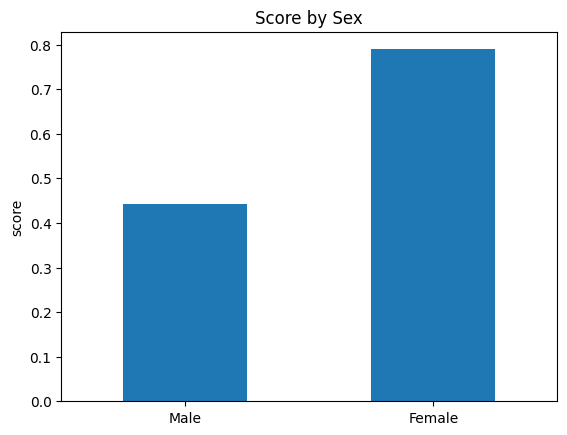

In [529]:
graph = disaggr[['sex', 'value']] \
             .head(2) \
             .rename(columns={'value': 'Score'}) \
             .replace({2: 'Female', 1: 'Male'})

plot = graph.plot.bar(ylabel='score', legend=False, title='Score by Sex')
plot.set_xticklabels(graph.sex, rotation=0)